# Loading/ Plotting Inputs

In [1]:
import pickle
import gzip
import numpy as np
from sklearn.preprocessing import normalize

data = np.load('data.npz')

In [85]:
X = data['X']
y = data['y']
y = y[:,1]
y = y[:, np.newaxis]
mu_y = data['mu_y']
stds_y = data['stds_y']

In [86]:
print(X.shape)
print(y.shape)

(2900, 4000, 2)
(2900, 1)


# Setting-up S4D Model

In [18]:
from models.s4d import S4D
import torch.nn as nn
dropout_fn = nn.Dropout2d

#d_input = X.shape[-1] # number of channels (here only one time series -> 1)
#d_output = y.shape[-1] # number of outputs (here regression, so one output, can be several, if we want to regress several quantities)
d_input = 2 # number of channels (here only one time series -> 1)
d_output = 1 # number of outputs (here regression, so one output, can be several, if we want to regress several quantities)

In [15]:
# definition of SSM here
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input, d_model)
        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))
        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)
        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)
        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)
        #x = torch.flatten(x)
        return x

In [19]:
# Model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('==> Building model..')
model = S4Model(d_input=d_input, d_output=d_output, d_model=6, n_layers=4, dropout=0.0, prenorm=False)
model = model.to(device)
print('...done!')

==> Building model..
...done!


In [20]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

3529


In [90]:
import torch.optim as optim
def setup_optimizer(model, lr, weight_decay, epochs):
    all_parameters = list(model.parameters())
    params = [p for p in all_parameters if not hasattr(p, "_optim")]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    #optimizer = optim.SGD(params, lr=lr, weight_decay=weight_decay)
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

criterion = nn.MSELoss()
optimizer, scheduler = setup_optimizer(model, lr=0.01, weight_decay=0.01, epochs=10)

Optimizer group 0 | 40 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 18 tensors | lr 0.001 | weight_decay 0.0


# Actual training

In [91]:
from torch.utils.data import random_split, DataLoader, Dataset
class Dataloader(Dataset):
    def __init__(self, X, y, norm=False):
        if norm:
            arr = {}
            for i in [0,1]:
                x = X[:,:,i]
                mu_X = np.mean(x, axis=1)[:, :, np.newaxis]
                stds_X = np.std(x, axis=1)[:, :, np.newaxis]
                arr[i] = (x-mu_X)/stds_X
            X = np.stack([arr[0],arr[1]], axis=-1)
        
        self.timeseries = np.float32(X)
        self.vars = np.float32(y)
        
    def __len__(self):
        return self.vars.shape[0]
    
    def __getitem__(self, idx):
        times = self.timeseries[idx, :, :]
        var = self.vars[idx]
        return times, var
    
fulldata = Dataloader(X, y)
generator = torch.Generator().manual_seed(42) 
trainset, valset, testset = torch.utils.data.random_split(fulldata, [0.7,0.1,0.2], generator=generator)

In [92]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

tensor([-1.2104])


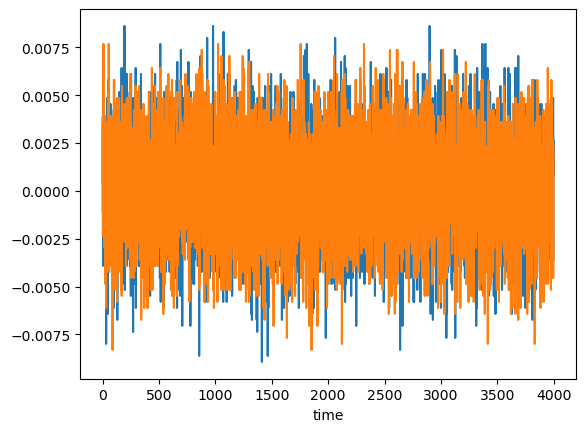

In [93]:
import matplotlib.pyplot as plt
batch = next(iter(train_loader))
plt.plot(batch[0][2].numpy())
plt.xlabel("time")
print(batch[1][2])

In [94]:
best_loss = np.inf  # best test loss
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
doc_loss = []
doc_val = []

In [95]:
import os

# Training
from tqdm.auto import tqdm
def train():
    model.train()
    train_loss = 0
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f ' %
            (batch_idx, len(train_loader), train_loss/(batch_idx+1))
        )
        doc_loss.append(train_loss/(batch_idx+1))

def eval(epoch, dataloader, checkpoint=False):
    global best_loss
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1))
            )
            doc_val.append(eval_loss/(batch_idx+1))

    # Save checkpoint.
    if checkpoint:
        if loss < best_loss:
            state = {
                'model': model.state_dict(),
                'loss': loss,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_loss = loss
        

        return loss

pbar = tqdm(range(start_epoch, 80))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val loss: %1.3f' % (epoch, val_loss))
    train()
    val_loss = eval(epoch, valid_loader, checkpoint=True)
    #eval(epoch, test_loader)
    scheduler.step()

Epoch: 0:   0%|          | 0/80 [00:00<?, ?it/s]
0it [00:00, ?it/s]
Batch Idx: (0/64) | Loss: 1.945 : : 0it [00:00, ?it/s]
Batch Idx: (1/64) | Loss: 1.520 : : 0it [00:00, ?it/s]
Batch Idx: (2/64) | Loss: 1.445 : : 0it [00:00, ?it/s]
Batch Idx: (3/64) | Loss: 1.317 : : 0it [00:00, ?it/s]
Batch Idx: (3/64) | Loss: 1.317 : : 4it [00:00, 36.32it/s]
Batch Idx: (4/64) | Loss: 1.251 : : 4it [00:00, 36.32it/s]
Batch Idx: (5/64) | Loss: 1.194 : : 4it [00:00, 36.32it/s]
Batch Idx: (6/64) | Loss: 1.193 : : 4it [00:00, 36.32it/s]
Batch Idx: (7/64) | Loss: 1.173 : : 4it [00:00, 36.32it/s]
Batch Idx: (7/64) | Loss: 1.173 : : 8it [00:00, 37.43it/s]
Batch Idx: (8/64) | Loss: 1.158 : : 8it [00:00, 37.43it/s]
Batch Idx: (9/64) | Loss: 1.127 : : 8it [00:00, 37.43it/s]
Batch Idx: (10/64) | Loss: 1.127 : : 8it [00:00, 37.43it/s]
Batch Idx: (11/64) | Loss: 1.116 : : 8it [00:00, 37.43it/s]
Batch Idx: (11/64) | Loss: 1.116 : : 12it [00:00, 37.99it/s]
Batch Idx: (12/64) | Loss: 1.109 : : 12it [00:00, 37.99it/s

### Plotting and diagnostics of training

In [74]:
loss = []
x = len(train_loader)
for i in range(0, len(doc_loss), x): loss.append(sum(doc_loss[i:i + x])/len(train_loader))

val = []
x = len(valid_loader)
for i in range(0, len(doc_val), x): val.append(sum(doc_val[i:i + x])/len(valid_loader))
epochs = np.arange(0,len(loss),1)

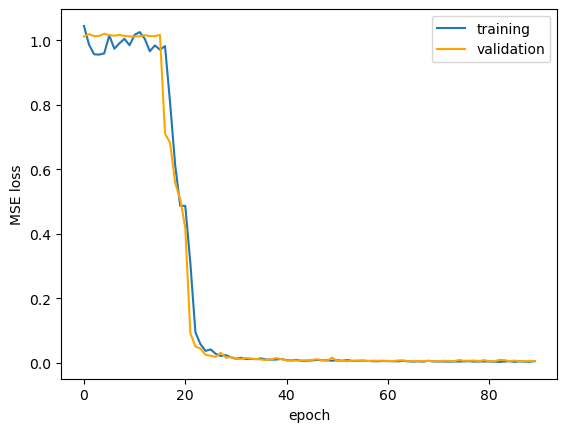

In [75]:
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val, c='orange', label='validation')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
#plt.ylim([0.0,0.45])
plt.legend()
plt.show()

# See the (physics) results

In [76]:
# run inference
pred = []
true = []
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        pred.append(model(inputs).detach().cpu().numpy())
        true.append(targets)
pred = np.concatenate(pred, axis=0)
true = np.concatenate(true, axis=0)

In [77]:
pred.shape

(580, 1)

In [78]:
# undo the normalization
pred_post = (pred*stds_y[0:2]+mu_y[0:2])
true_post = (true*stds_y[0:2]+mu_y[0:2])

In [79]:
true_post.shape

(580, 2)

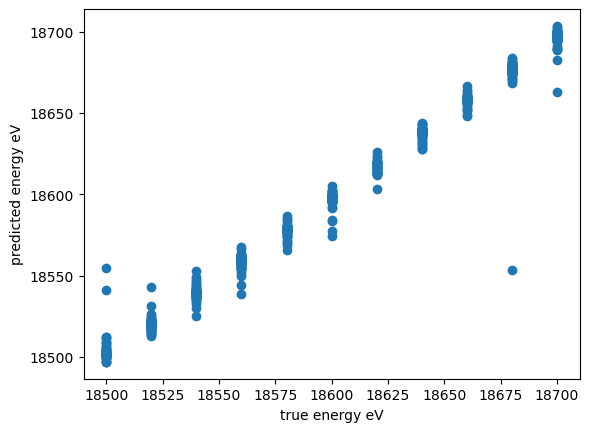

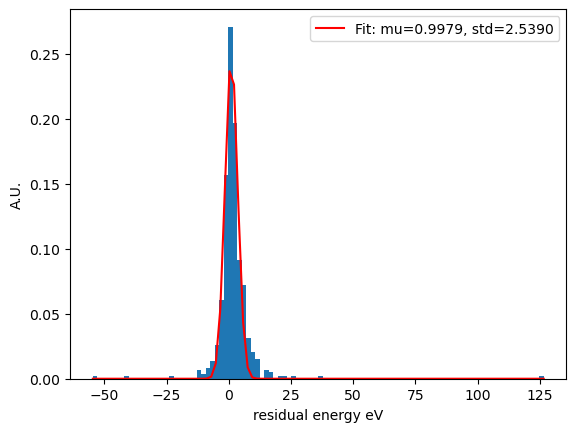

In [81]:
from scipy.optimize import curve_fit
from scipy.stats import norm

nfeature = 0
label = 'energy'
unit = 'eV'

plt.scatter(true_post[:,nfeature],pred_post[:,nfeature])
plt.xlabel('true ' + label + ' '+ unit)
plt.ylabel('predicted ' + label + ' ' + unit)
plt.show()

nentries = true_post.shape[0]
data = true_post[:,nfeature]-pred_post[:,nfeature]

hist, bins, _ = plt.hist(data,bins=100,weights=np.ones(nentries)*1/float(nentries))
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)
bin_centers = (bins[:-1] + bins[1:]) / 2
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), np.mean(data), np.std(data)])
amplitude_fit, mean_fit, stddev_fit = popt

x_fit = np.linspace(min(bins), max(bins), 100)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit: mu={:.4f}, std={:.4f}'.format(mean_fit, stddev_fit))

plt.xlabel('residual '+label+ ' '+unit)
plt.ylabel('A.U.')
plt.legend()

# Display the plot
plt.show()

In [82]:
len(epochs)

90